In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [2]:
with open("simu5_data/simu5_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 30]
# df_test = df_test.loc[df_test.session < 30]

In [3]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,list,session
0,1071,857,PIMPLE,MAILBOX,0,0
1,309,1029,CIGARETTE,PAW,0,0
2,624,700,GARLIC,HEEL,0,0
3,195,1389,BULLETIN,STRANGER,0,0
4,580,392,FLIPPER,COUSIN,0,0
...,...,...,...,...,...,...
467995,1281,1100,SHELL,POLYESTER,77,999
467996,1511,421,TROUT,CUCUMBER,77,999
467997,1269,640,SERGEANT,GLASSES,77,999
467998,1495,1017,TRAITOR,PARTNER,77,999


In [4]:
df_test

,test_itemno,test_item,correct_ans,lag,list,session
0,580,FLIPPER,392,1,0,0
1,744,IRON,245,3,1,0
2,316,CLAMP,958,5,2,0
3,109,BEAVER,1326,2,3,0
4,768,KANGAROO,1632,0,4,0
...,...,...,...,...,...,...
77995,129,BIRD,67,4,73,999
77996,616,FURNITURE,1451,5,74,999
77997,1082,PLANET,344,4,75,999
77998,100,BATHTUB,192,5,76,999


### Run CMR-IA

In [5]:
s_mat = np.load('../../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_cue = 0.45,
    beta_distract = 0.1,
    beta_rec_post = 0.99,
    gamma_fc = 0.7,
    gamma_cf = 0.5,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    kappa = 0.08,
    lamb = 0.05,
    eta = 0.02,
    phi_s = 1.6,  # control the overall f_dif correct
    phi_d = 1.1,  # control the curve of last three, higher then upper, mediated by phi_s 
    nitems_in_accumulator = 48,
    d_ass = 0.8,
    alpha = 0.5,
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.5,
 'beta_cue': 0.45,
 'beta_rec_post': 0.99,
 'beta_distract': 0.1,
 'phi_s': 1.6,
 'phi_d': 1.1,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.08,
 'eta': 0.02,
 'omega': 5,
 'alpha': 0.5,
 'c_thresh': 0.01,
 'c_thresh_itm': 0.5,
 'c_thresh_ass': 0.5,
 'd_ass': 0.8,
 'lamb': 0.05,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 48,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.7,
 'gamma_cf': 0.5}

In [7]:
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 5229.822053194046


,list,session,test_itemno,s_resp,s_rt,csim
0,0,0,580,1605.0,1620.0,0.893381
1,1,0,744,1436.0,2600.0,0.862758
2,2,0,316,1575.0,1670.0,0.829016
3,3,0,109,1080.0,2300.0,0.866053
4,4,0,768,1495.0,3070.0,0.777402
...,...,...,...,...,...,...
77995,73,999,129,67.0,3270.0,0.726532
77996,74,999,616,549.0,3380.0,0.844808
77997,75,999,1082,344.0,2300.0,0.727427
77998,76,999,100,688.0,2780.0,0.841709


In [8]:
df_simu = df_simu.merge(df_test,on=['session','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,correct
0,0,0,580,1605.0,1620.0,0.893381,FLIPPER,392,1,0,False
1,1,0,744,1436.0,2600.0,0.862758,IRON,245,3,1,False
2,2,0,316,1575.0,1670.0,0.829016,CLAMP,958,5,2,False
3,3,0,109,1080.0,2300.0,0.866053,BEAVER,1326,2,3,False
4,4,0,768,1495.0,3070.0,0.777402,KANGAROO,1632,0,4,False
...,...,...,...,...,...,...,...,...,...,...,...
77995,73,999,129,67.0,3270.0,0.726532,BIRD,67,4,73,True
77996,74,999,616,549.0,3380.0,0.844808,FURNITURE,1451,5,74,False
77997,75,999,1082,344.0,2300.0,0.727427,PLANET,344,4,75,True
77998,76,999,100,688.0,2780.0,0.841709,BATHTUB,192,5,76,False


In [9]:
# f_in

In [10]:
sessions = df_simu.session.to_numpy()
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)

    this_df = df_simu.query(f"session=={sess}")
    testid = np.searchsorted(tmp, this_df.test_itemno)
    corrid = np.searchsorted(tmp, this_df.correct_ans)

    df_simu.loc[df_simu.session == sess, 'corr_fin'] = [f_dif[sess][l][i] for l,i in enumerate(corrid)]
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = [np.delete(f_dif[sess][l], i).max() for l,i in enumerate(corrid)]

df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,correct,corr_fin,omax_fin
0,0,0,580,1605.0,1620.0,0.893381,FLIPPER,392,1,0,False,-0.177620,-0.194986
1,1,0,744,1436.0,2600.0,0.862758,IRON,245,3,1,False,-0.263665,-0.226055
2,2,0,316,1575.0,1670.0,0.829016,CLAMP,958,5,2,False,-0.323507,-0.235902
3,3,0,109,1080.0,2300.0,0.866053,BEAVER,1326,2,3,False,-0.263566,-0.200590
4,4,0,768,1495.0,3070.0,0.777402,KANGAROO,1632,0,4,False,-0.129559,-0.317144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77995,73,999,129,67.0,3270.0,0.726532,BIRD,67,4,73,True,-0.227613,-0.260517
77996,74,999,616,549.0,3380.0,0.844808,FURNITURE,1451,5,74,False,-0.282686,-0.193426
77997,75,999,1082,344.0,2300.0,0.727427,PLANET,344,4,75,True,-0.247836,-0.217527
77998,76,999,100,688.0,2780.0,0.841709,BATHTUB,192,5,76,False,-0.246715,-0.240829


In [16]:
df_simu.to_pickle("simu5_data/simu5_result.pkl")

### PLOT

In [17]:
with open("simu5_data/simu5_result.pkl", 'rb') as inp:
    df_simu = pickle.load(inp)

In [18]:
df_fin = df_simu.groupby('lag')[['corr_fin','omax_fin']].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

,lag,corr_fin,omax_fin,dif
0,0,-0.127831,-0.294478,0.166647
1,1,-0.179603,-0.213708,0.034105
2,2,-0.225999,-0.221441,-0.004558
3,3,-0.258400,-0.227865,-0.030536
4,4,-0.266588,-0.233828,-0.032760
5,5,-0.279830,-0.238368,-0.041461


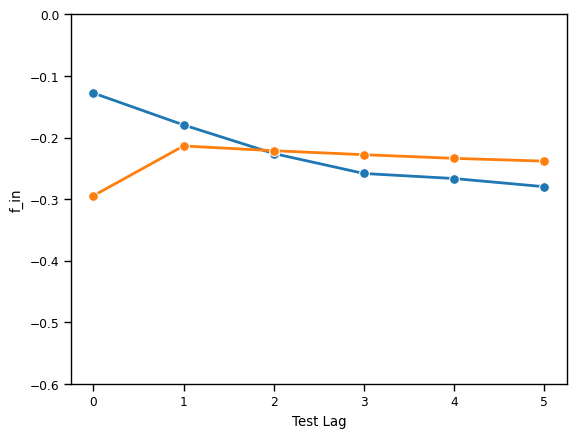

In [19]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7)
# sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7)
plt.ylim([-0.6,0])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

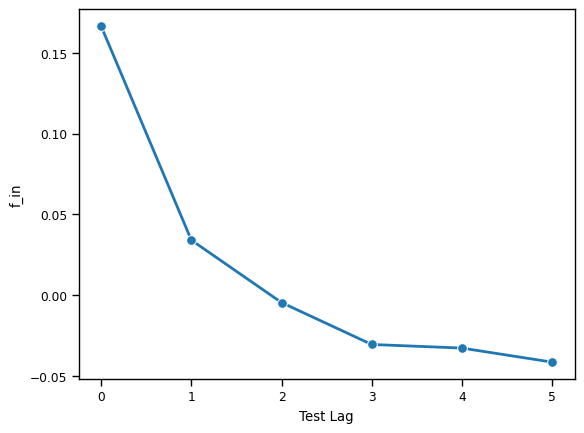

In [20]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

In [21]:
df_laggp = df_simu.groupby(['lag']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,corr_rate
0,0,0.850412
1,1,0.481565
2,2,0.307710
3,3,0.229722
4,4,0.232897
5,5,0.220087


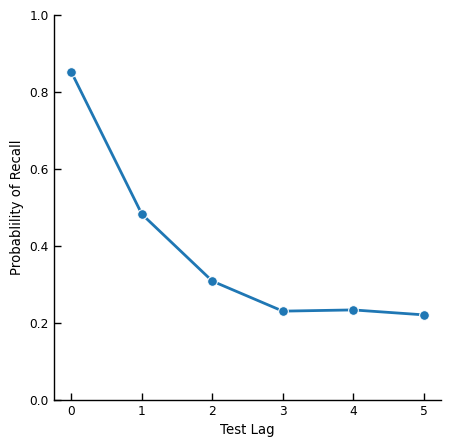

In [22]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
plt.savefig('simu5_fig/simu5_recall.pdf')
plt.show()